Stitched image saved as 'stitched_result.jpg'


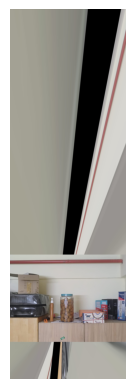

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stitch_images_sift(image1, image2):
    """
    Stitches two images using SIFT feature detection and homography.
    """
    # Convert images to grayscale for better feature detection
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    if descriptors1 is None or descriptors2 is None:
        print("Feature detection failed. Try different images or tuning SIFT parameters.")
        return None

    # Use Brute Force Matcher with L2 norm
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = matcher.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda m: m.distance)  # Sort by match quality

    # Select good matches (tune this threshold if needed)
    best_matches = matches[:50]

    # Extract coordinates of matched keypoints
    source_pts = np.float32([keypoints1[m.queryIdx].pt for m in best_matches]).reshape(-1, 1, 2)
    dest_pts = np.float32([keypoints2[m.trainIdx].pt for m in best_matches]).reshape(-1, 1, 2)

    # Compute homography using RANSAC
    homography_matrix, status = cv2.findHomography(source_pts, dest_pts, cv2.RANSAC, 5.0)
    if homography_matrix is None:
        print("Homography calculation failed. Check if there are enough good matches.")
        return None

    # Get image dimensions
    height1, width1 = image1.shape[:2]
    height2, width2 = image2.shape[:2]

    # Determine the transformed coordinates of image1
    corners_image1 = np.float32([[0, 0], [0, height1], [width1, height1], [width1, 0]]).reshape(-1, 1, 2)
    transformed_corners = cv2.perspectiveTransform(corners_image1, homography_matrix)

    # Compute the size of the stitched image
    all_corners = np.concatenate((transformed_corners, corners_image1), axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    translation_offset = [-x_min, -y_min]
    translation_matrix = np.array([[1, 0, translation_offset[0]],
                                   [0, 1, translation_offset[1]],
                                   [0, 0, 1]], dtype=np.float32)

    # Warp image1 onto the new coordinate system
    stitched_width = x_max - x_min
    stitched_height = y_max - y_min
    result = cv2.warpPerspective(image1, translation_matrix.dot(homography_matrix), (stitched_width, stitched_height))

    # Place image2 onto the stitched canvas
    result[translation_offset[1]:translation_offset[1]+height2,
           translation_offset[0]:translation_offset[0]+width2] = image2

    return result

def main():
    # Load images (modify paths accordingly)
    img1 = cv2.imread('panaroma1.jpeg')
    img2 = cv2.imread('panaroma2.jpeg')

    if img1 is None or img2 is None:
        print("Error: Could not read one or both images. Check file paths.")
        return

    # Perform stitching
    stitched_image = stitch_images_sift(img1, img2)
    if stitched_image is not None:
        cv2.imwrite('stitched_result.jpg', stitched_image)
        print("Stitched image saved as 'stitched_result.jpg'")

        # Display the result
        plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Image stitching failed.")

if __name__ == "__main__":
    main()


Stitched panorama saved as 'stitched_panorama.jpg'


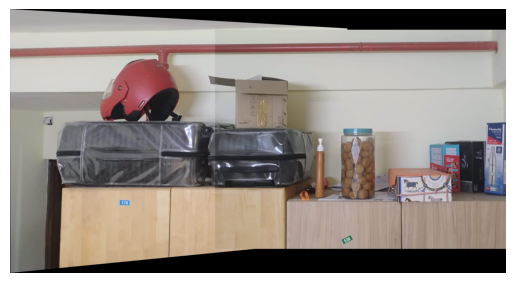

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stitch_images(img1, img2):
    # Step 1: Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Step 2: Detect keypoints and compute descriptors using SIFT
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Check if descriptors were successfully computed
    if descriptors1 is None or descriptors2 is None:
        print("Error: Could not find features in one of the images.")
        return None

    # Step 3: Match keypoints using BFMatcher with L2 norm
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = matcher.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda match: match.distance)

    # Use a subset of the best matches for homography estimation
    num_matches = 50
    best_matches = matches[:num_matches]

    # Extract location of good matches
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in best_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in best_matches]).reshape(-1, 1, 2)

    # Step 4: Compute the homography using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if H is None:
        print("Error: Homography could not be computed.")
        return None

    # Step 5: Warp img1 to img2's coordinate system and stitch
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Compute the transformed corners of img1
    corners_img1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Find the overall bounding box for the panorama
    all_corners = np.concatenate((warped_corners, np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)), axis=0)
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    # Calculate translation to shift the panorama so that all pixels are positive
    translation_dist = [-x_min, -y_min]
    translation_matrix = np.array([[1, 0, translation_dist[0]],
                                   [0, 1, translation_dist[1]],
                                   [0, 0, 1]], dtype=np.float32)

    # Warp img1 using the combined transformation
    result_width = x_max - x_min
    result_height = y_max - y_min
    stitched_image = cv2.warpPerspective(img1, translation_matrix.dot(H), (result_width, result_height))

    # Place img2 on the stitched canvas
    stitched_image[translation_dist[1]:translation_dist[1]+h2, translation_dist[0]:translation_dist[0]+w2] = img2

    return stitched_image

def main():
    # Load images (update these file names as needed)
    image1 = cv2.imread('panaroma1.jpeg')
    image2 = cv2.imread('panaroma2.jpeg')

    if image1 is None or image2 is None:
        print("Error: One or both images could not be loaded. Check file paths.")
        return

    # Stitch the images together
    panorama = stitch_images(image1, image2)
    if panorama is not None:
        # Save the result
        cv2.imwrite('stitched_panorama.jpg', panorama)
        print("Stitched panorama saved as 'stitched_panorama.jpg'")

        # Display the stitched panorama
        plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Image stitching failed.")

if __name__ == '__main__':
    main()


Stitched panorama saved as 'stitched_panorama.jpg'


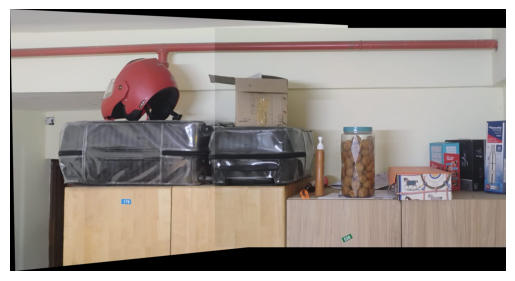

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stitch_images(img1, img2):
    # Step 1: Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Step 2: Detect keypoints and compute descriptors using SIFT
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Check if descriptors were successfully computed
    if descriptors1 is None or descriptors2 is None:
        print("Error: Could not find features in one of the images.")
        return None

    # Step 3: Match keypoints using BFMatcher with L2 norm
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = matcher.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda match: match.distance)

    # Use all matches for homography estimation
    all_matches = matches

    # Check if we have enough matches (at least 4 are needed to compute a homography)
    if len(all_matches) < 4:
        print("Error: Not enough matches to compute homography.")
        return None

    # Extract location of matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in all_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in all_matches]).reshape(-1, 1, 2)

    # Step 4: Compute the homography using RANSAC
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if H is None:
        print("Error: Homography could not be computed.")
        return None

    # Step 5: Warp img1 to img2's coordinate system and stitch
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Compute the transformed corners of img1
    corners_img1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Find the overall bounding box for the panorama
    all_corners = np.concatenate(
        (warped_corners, np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)),
        axis=0
    )
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    # Calculate translation to shift the panorama so that all pixels are positive
    translation_dist = [-x_min, -y_min]
    translation_matrix = np.array([[1, 0, translation_dist[0]],
                                   [0, 1, translation_dist[1]],
                                   [0, 0, 1]], dtype=np.float32)

    # Warp img1 using the combined transformation
    result_width = x_max - x_min
    result_height = y_max - y_min
    stitched_image = cv2.warpPerspective(img1, translation_matrix.dot(H), (result_width, result_height))

    # Place img2 on the stitched canvas
    stitched_image[translation_dist[1]:translation_dist[1]+h2,
                   translation_dist[0]:translation_dist[0]+w2] = img2

    # ----------------------
    # Minimal Blending Step
    # ----------------------
    # Define the overlap region in the stitched image
    overlap_x1 = translation_dist[0]
    overlap_y1 = translation_dist[1]
    overlap_x2 = overlap_x1 + w2
    overlap_y2 = overlap_y1 + h2

    # Clip overlap to stitched_image bounds
    overlap_x1_clipped = max(overlap_x1, 0)
    overlap_y1_clipped = max(overlap_y1, 0)
    overlap_x2_clipped = min(overlap_x2, stitched_image.shape[1])
    overlap_y2_clipped = min(overlap_y2, stitched_image.shape[0])

    # If there is a valid overlapping region
    if overlap_x1_clipped < overlap_x2_clipped and overlap_y1_clipped < overlap_y2_clipped:
        # Extract the overlapping area from the stitched image
        region_stitched = stitched_image[overlap_y1_clipped:overlap_y2_clipped,
                                         overlap_x1_clipped:overlap_x2_clipped]
        # Extract the corresponding area from img2
        region_img2 = img2[overlap_y1_clipped - overlap_y1:overlap_y2_clipped - overlap_y1,
                           overlap_x1_clipped - overlap_x1:overlap_x2_clipped - overlap_x1]

        # Blend them with an alpha factor (0.5 means simple average)
        alpha = 0.5
        blended_region = cv2.addWeighted(region_stitched, alpha, region_img2, 1 - alpha, 0)

        # Place the blended result back into the stitched image
        stitched_image[overlap_y1_clipped:overlap_y2_clipped,
                       overlap_x1_clipped:overlap_x2_clipped] = blended_region

    return stitched_image

def main():
    # Load images (update these file names as needed)
    image1 = cv2.imread('panaroma1.jpeg')
    image2 = cv2.imread('panaroma2.jpeg')

    if image1 is None or image2 is None:
        print("Error: One or both images could not be loaded. Check file paths.")
        return

    # Stitch the images together
    panorama = stitch_images(image1, image2)
    if panorama is not None:
        # Save the result
        cv2.imwrite('stitched_panorama.jpg', panorama)
        print("Stitched panorama saved as 'stitched_panorama.jpg'")

        # Display the stitched panorama
        plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("Image stitching failed.")

if __name__ == '__main__':
    main()
